In [2]:
from importlib import reload
import brownian
import time_series
reload(brownian)
reload(time_series)
from time_series import find_files, find_ders, Collection, bin_func

from scipy.signal import detrend
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import numpy as np

In [261]:
ders = find_ders("/mnt/ext/data")[-3]
ders = find_ders(find_ders(ders)[0])
ders

['/mnt/ext/data/20211215/bead1/pulse1']

In [262]:
def sort_fnames(fnames, include=None):
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

In [263]:
sort_fnames(fnames, include=[1,3])

['/mnt/ext/data/20211215/bead1/pulse1/iter_1.tdms',
 '/mnt/ext/data/20211215/bead1/pulse1/iter_3.tdms']

100
(2.0207267652456813e-05, 1333.9714507269575, 642383.9727627985)
100
(2.1652578533652458e-05, 1393.4234911490403, 664473.1331191697)
100
(2.236082256800264e-05, 1419.2241712770922, 663539.683294139)
100
(2.1756659545980456e-05, 1410.7304645201018, 644716.3496046019)
100
(2.128072865626731e-05, 1369.5995038606834, 624349.6318021328)
100
(2.1915841463793063e-05, 1411.083919736254, 638844.4086687175)
100
(2.2188603484214744e-05, 1436.2380359422982, 665393.0302682277)
100
(2.2242271309782117e-05, 1428.1856324637643, 637651.1824356755)


Text(0.5, 0, 'Frequency (Hz)')

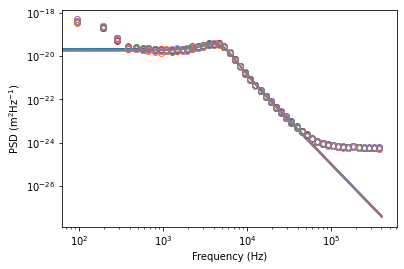

In [279]:
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
ders = ['/mnt/ext/data/20211215/bead1/pulse1']
der = ders[0]

fmin = 5e2
fmax = 4e4


fig, ax = plt.subplots(1,1, figsize=(6,4))


Npts = 32
krhoAs = []
for fnamei, fname in enumerate(sort_fnames(find_files(der), include=[1,2,3,4,5,6,7,8])):
    color = f"C{fnamei}"
    C = Collection(fname)
    T = np.mean(C.Ts) + 273.15
    C.set_collection("X", bin_average=Npts)
    C.apply("detrend", inplace=True, mode="constant")
    freq, psd = C.average("PSD", taumax=100e-3)
    mask = np.logical_and(freq>fmin, freq<fmax)
    print(C.Navg_psd)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    krhoA = get_krhoA(*abc, C.R, T)
    k, rho, A = krhoA
    print(krhoA)
    krhoAs.append(krhoA)
    logfreq  = logbin_func(freq, Npts=20)
    logpsd  = logbin_func(psd, Npts=20)
    logmask = np.logical_and(logfreq>fmin, logfreq<fmax)
    ax.loglog(logfreq, logpsd/A/A, mec=color, mfc="none", marker="o", ls="none")
    ax.loglog(freq, psd_func(freq, k, rho, T, C.R), c=color)
krhoAs = np.array(krhoAs)
ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
ax.set_xlabel(r"Frequency (Hz)")

In [235]:
C.R*2

3.17e-06

In [274]:
krhoAs.shape

(8, 3)

In [276]:
cal = 1 / np.mean(krhoAs[:, 2])

0.0007731199999999999 -0.013196335022530998
0.00080164 -0.01406662988884647
0.0008301600000000001 -0.011767269912643812
0.0008586800000000002 -0.011616157552553512
0.0008884400000000001 -0.011125173897789907
0.0009169600000000001 -0.010134786704707303
0.00094672 -0.009844081721323453
0.0009752399999999998 -0.008575064925890327


Text(0.5, 0, 'Time ($\\mu$s)')

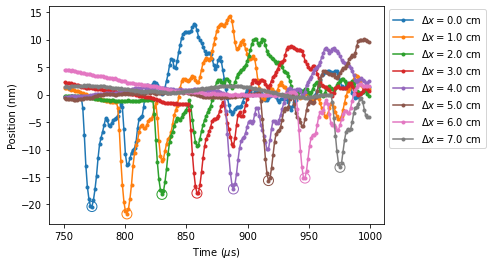

In [278]:
ders = ['/mnt/ext/data/20211215/bead1/pulse1']
der = ders[0]




fig, ax = plt.subplots(1,1, figsize=(6,4))


Npts = 32
tmin = 750e-6
tmax = 1000e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(find_files(der), include=[1,2,3,4,5,6,7,8])):
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("X", bin_average=Npts)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    print(tpeak, Vpeak)
    ax.plot(1e6*tm, 1e9*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos)
    ax.scatter([1e6*tpeak], [1e9*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

ax.set_ylabel("Position (nm)")
ax.set_xlabel(r"Time ($\mu$s)")

344.75276791627704


Text(0.2, 175, 'Speed: 344.75 m/s')

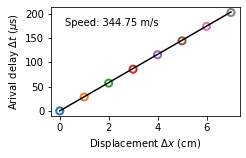

In [201]:
fig, ax = plt.subplots(1,1, figsize=(3.375, 2))
def slope(x, m):
    return m*x


popt, pcov = curve_fit(slope, poses, delta_ts, p0=[1/344.0], bounds=[(0,), (np.inf)])
speed = 1 / popt[0]
print(speed*1e-2)
plt.plot(poses, 1e6*poses/speed, c="k")
for fnamei, (pos, dt) in enumerate(zip(poses, delta_ts)):
    color = f"C{fnamei}"
    ax.scatter([pos], [1e6*dt],  marker="o", ec=color, fc="none", s=50, lw=2)
ax.set_ylabel("Arival delay $\Delta t$ ($\mu$s)")
ax.set_xlabel("Displacement $\Delta x$ (cm)")
ax.text(0.2, 175, f"Speed: {round(speed*1e-2, 2)} m/s")

In [149]:
poses

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [166]:
poses, delta_ts

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([0.0000e+00, 2.8520e-05, 5.7040e-05, 8.5560e-05, 1.1532e-04,
        1.4384e-04, 1.7360e-04, 2.0212e-04]))

In [138]:
ders = find_ders("/mnt/ext/data")[-4]
fname = find_files(find_ders(ders)[1])[0]
C = Collection(fname)
C.set_collection("X")
t, _ = C.collection[0]()

In [199]:
idx = 7
x = C.Xs[idx]
x = detrend(x)

y0 = C.Ys[idx]
y0 = bin_func(y0, dt=1/C.r, taumax=10/C.r)
y0 = detrend(y0)
norm = np.sqrt(np.var(x) / np.var(y0))
t0 = bin_func(t, dt=1/C.r, taumax=10/C.r)
ynorm = np.interp(t, t0, norm*y0)

/tmp/ipykernel_2591/2236042870.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(poses, 1e-1/poses**2)


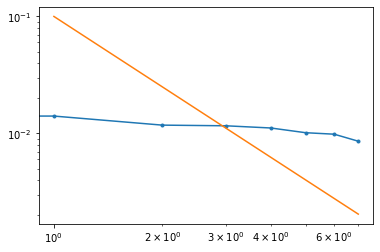

In [183]:
plt.loglog(poses, np.abs(Vpeaks), marker=".")
plt.loglog(poses, 1e-1/poses**2)

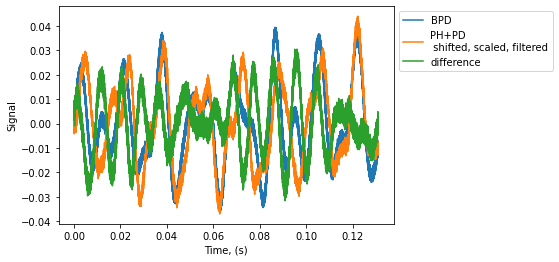

In [205]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(t, x, label="BPD")
ax.plot(t, ynorm, label="PH+PD \n shifted, scaled, filtered")
ax.plot(t, x-ynorm, label="difference")
plt.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Signal")
ax.set_xlabel("Time, (s)")
plt.savefig("figures/BPD-PHPD_compare.pdf", bbox_inches="tight")